# Proxy Database Comparisons

## Author
[Tanaya Gondhalekar](https://orcid.org/0009-0004-2440-3266)

We want to see what the difference is in the proxy databases for those that were included before interpolation vs. after. If the reconstructions are drastically different, it is important to note what those differences can be attributed to.

This is similar to the analysis performed in [_Proxy Database Forensics_](https://linked.earth/reproduce_lmr_pb/notebooks/validation/C03_b_comparison.html).

In [1]:
import cfr
import pickle 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Comparing Interpolated vs. Non-Interpolated PReSto2k databases

This comparison is straightforward. Since The only difference here should be the 27 records that got added in during the interpolation step, we can easily use `cfr`'s diff operator to directly subtract one from the other to identify the additional records. By doing this, if one reconstruction is significantly better or worse, we can more easily pinpoint which records are the cause. 

In [2]:
print("Loading from pickle...")
with open('./prev_data/pdb_w_seasonality_annual.pkl', 'rb') as f:
    no_interp = pickle.load(f)

print(f"Loaded {no_interp.nrec} records from pickle")

print("Loading from pickle...")
with open('./prev_data/pdb_w_seasonality_annual_interp.pkl', 'rb') as f:
    with_interp = pickle.load(f)

print(f"Loaded {with_interp.nrec} records from pickle")

Loading from pickle...
Loaded 559 records from pickle
Loading from pickle...
Loaded 586 records from pickle


In [3]:
no_interp_pdb = no_interp
with_interp_pdb = with_interp

diff = with_interp_pdb-no_interp_pdb

(<Figure size 1000x1000 with 1 Axes>,
 {'map': <GeoAxes: title={'center': 'Interpolated Records'}>})

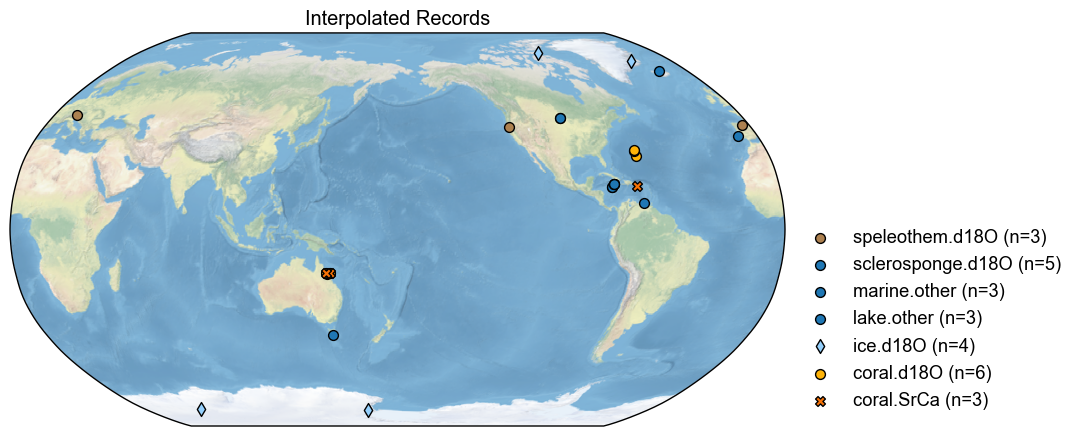

In [4]:
diff.plot(title='Interpolated Records')

## Comparing Original PAGES2k with PReSto2k

This second comparison proves to be much more difficult. Here we compare the ProxyDatabase used in our reproduction of LMRv2.1. 
Because the PID naming convention between PAGES2k in _cfr_ and those pulled from the LiPDGraph are slightly different, despite possibly containing a majority of the same actual records, we have to create additional filters to catch all the similarities and differences. To bypass this without overcomplicating the names, we will use the following function `match_pid_name` to check each record between two proxy databases and make sure their lat, lon, and values match without regarding the PID. 

In [5]:
# load original used in LMRv2.1 reproduction

pdb_og = cfr.ProxyDatabase().load_nc('./prev_data/pdb/filtered_ptype_res_cfr_pages2kv2.nc')
pdb_og.refresh()

We want the preferred pid map to be the pdb1 in the function, so when we use `rename_pids`, the `no_interp_pdb` names will change to the ones in `pdb_og`, which match the orignal naming convention used by _cfr_.

`rename_pids` matches proxy records between two proxy databases using a multi-pass strategy that becomes progressively more flexible. It starts with manual overrides for known pairs, then tries exact location + proxy type + value matches, followed by value-only matches, location-only matches with value prioritization, and finally pure value-based matches with stricter overlap requirements. The goal is to identify corresponding records across databases that may have different naming conventions but represent the same paleoclimate data, through as many steps as can filter out incorrect matches or duplicate matches. 

In [6]:
import re

def _pid_num(pid):
    """
    Extract the trailing numeric portion of a proxy record ID.

    Parameters
    ----------
    pid : str or int
        Proxy record identifier (e.g., "Ocn_112"). Can be any object
        convertible to string.

    Returns
    -------
    int or None
        The integer found at the end of the string if present,
        otherwise None.
    """
    m = re.search(r'(\d+)$', str(pid))
    return int(m.group(1)) if m else None

def values_match(v1, v2, t1, t2, min_overlap_fraction=0.7, min_correlation=0.8):
    """
    Test whether two proxy value series represent the same underlying record
    based on overlapping time coverage and statistical similarity.

    The function compares two time/value series over their common overlap
    period. It checks (1) that enough of each record overlaps, and (2) that
    the values are sufficiently correlated or numerically close.

    Parameters
    ----------
    v1, v2 : array_like
        Value arrays for the two records.
    t1, t2 : array_like
        Time arrays corresponding to ``v1`` and ``v2``.
    min_overlap_fraction : float, optional
        Minimum fraction of overlap (by number of points) required between
        the two series. Default is 0.7.
    min_correlation : float, optional
        Minimum Pearson correlation coefficient required when comparing
        overlapping segments. Default is 0.8.

    Returns
    -------
    bool
        True if the two series are judged to match, False otherwise.
    """
    if len(v1) == 0 or len(v2) == 0:
        return False
        
    # Find overlap
    common_start = max(t1[0], t2[0])
    common_end = min(t1[-1], t2[-1])
    
    mask1 = (t1 >= common_start) & (t1 <= common_end)
    mask2 = (t2 >= common_start) & (t2 <= common_end)
    
    v1_overlap = v1[mask1]
    v2_overlap = v2[mask2]
    
    # More lenient overlap check
    overlap_frac = min(len(v1_overlap) / len(v1), len(v2_overlap) / len(v2))
    
    if overlap_frac >= min_overlap_fraction and len(v1_overlap) > 10:
        if len(v1_overlap) == len(v2_overlap):
            # Same length - use both correlation and closeness
            if len(v1_overlap) > 1:  # Need at least 2 points for correlation
                corr = np.corrcoef(v1_overlap, v2_overlap)[0,1]
                close = np.allclose(v1_overlap, v2_overlap, atol=1e-6, equal_nan=True)
                return (not np.isnan(corr) and corr >= min_correlation) or close
            else:
                return np.allclose(v1_overlap, v2_overlap, atol=1e-6, equal_nan=True)
        else:
            # Different lengths - just check if they're close after interpolation to shorter length
            min_len = min(len(v1_overlap), len(v2_overlap))
            if min_len > 10:
                # Simple downsampling to same length
                v1_sampled = v1_overlap[::len(v1_overlap)//min_len][:min_len]
                v2_sampled = v2_overlap[::len(v2_overlap)//min_len][:min_len]
                if len(v1_sampled) == len(v2_sampled) and len(v1_sampled) > 1:
                    corr = np.corrcoef(v1_sampled, v2_sampled)[0,1]
                    return not np.isnan(corr) and corr >= min_correlation
    
    return False

def match_proxy_records(pdb1, pdb2, tol_deg=0.03):
    """
    Match proxy records between two databases using a multi-pass strategy.

    Matching proceeds in several stages:
      1. Apply manual overrides for known ID pairs.
      2. Location + proxy type + value similarity, with PID numeric tiebreak.
      3. Value-only matches (when no location match exists).
      4. Location-only matches, prioritizing value similarity.
      5. Pure value-based matches with stricter overlap requirements.

    Parameters
    ----------
    pdb1 : ProxyDatabase
        First proxy database object. Must have a ``records`` dict mapping
        record IDs to objects with attributes ``lat``, ``lon``, ``ptype``,
        ``time``, and ``value``.
    pdb2 : ProxyDatabase
        Second proxy database object, same requirements as ``pdb1``.
    tol_deg : float, optional
        Tolerance in degrees for considering two locations to be the same.
        Default is 0.03 (~3 km).

    Returns
    -------
    matches : dict
        Mapping from record IDs in ``pdb1`` to their matched record IDs in ``pdb2``.
    conflicts : dict
        Dictionary of unresolved or conflicting matches. Keys are ``pdb2`` IDs,
        values are lists of candidate ``pdb1`` IDs.
    missing : list
        List of record IDs in ``pdb1`` that could not be matched.
    """
    matches, conflicts, missing = {}, {}, []
    used_right = set()

    # Manual overrides first
    manual_matches = {
        'Ocn_112': 'Ocean2kHR_100',
        'Ocn_095': 'Ocean2kHR_156', 
        'Ant_019': 'Ant_033',
        'Ocn_091': 'Ocean2kHR_157',
        'Ocn_093': 'Ocean2kHR_158'
    }
    
    for pages_pid, presto_pid in manual_matches.items():
        if pages_pid in pdb1.records and presto_pid in pdb2.records:
            matches[pages_pid] = presto_pid
            used_right.add(presto_pid)

    # Pass 1: location + ptype + values + PID tiebreaker
    for pid1, r1 in pdb1.records.items():
        if pid1 in matches:
            continue
            
        cands = [pid2 for pid2, r2 in pdb2.records.items()
                 if (r2.ptype == r1.ptype and
                     abs(r1.lat - r2.lat) <= tol_deg and
                     abs(r1.lon - r2.lon) <= tol_deg and
                     pid2 not in used_right)]

        if len(cands) == 1:
            matches[pid1] = cands[0]
            used_right.add(cands[0])
        elif len(cands) > 1:
            # Try values, then PID tiebreaker
            value_cands = [pid2 for pid2 in cands 
                          if values_match(
                              np.asarray(r1.value), np.asarray(pdb2.records[pid2].value),
                              np.asarray(r1.time), np.asarray(pdb2.records[pid2].time))]
            
            if len(value_cands) == 1:
                matches[pid1] = value_cands[0]
                used_right.add(value_cands[0])
            elif len(value_cands) > 1:
                # PID tiebreaker
                n1 = _pid_num(pid1)
                if n1:
                    pid_match = [pid2 for pid2 in value_cands if _pid_num(pid2) == n1]
                    if len(pid_match) == 1:
                        matches[pid1] = pid_match[0]
                        used_right.add(pid_match[0])

    # Pass 2: values-only
    for pid1, r1 in pdb1.records.items():
        if pid1 in matches:
            continue
            
        value_matches = [pid2 for pid2, r2 in pdb2.records.items()
                        if (pid2 not in used_right and
                            values_match(
                                np.asarray(r1.value), np.asarray(r2.value),
                                np.asarray(r1.time), np.asarray(r2.time)))]

        if len(value_matches) == 1:
            matches[pid1] = value_matches[0]
            used_right.add(value_matches[0])

    # Mark remaining as missing
    for pid1 in pdb1.records:
        if pid1 not in matches:
            missing.append(pid1)

    # Pass 3: Location-only with value priority
    for pid1, r1 in pdb1.records.items():
        if pid1 in matches:
            continue
            
        # Find all records at same location regardless of ptype
        location_matches = []
        for pid2, r2 in pdb2.records.items():
            if (pid2 not in used_right and
                abs(r1.lat - r2.lat) <= tol_deg and
                abs(r1.lon - r2.lon) <= tol_deg):
                location_matches.append(pid2)
        
        if len(location_matches) == 1:
            matches[pid1] = location_matches[0]
            used_right.add(location_matches[0])
        elif len(location_matches) > 1:
            # Prioritize value matching
            value_matches = [pid2 for pid2 in location_matches
                            if values_match(
                                np.asarray(r1.value), np.asarray(pdb2.records[pid2].value),
                                np.asarray(r1.time), np.asarray(pdb2.records[pid2].time))]
            
            if len(value_matches) == 1:
                matches[pid1] = value_matches[0]
                used_right.add(value_matches[0])
            elif len(value_matches) == 0:
                # No value matches - leave unmatched rather than guess
                continue
            else:
                # Multiple value matches - only use PID as very last resort
                n1 = _pid_num(pid1)
                if n1:
                    pid_matches = [pid2 for pid2 in value_matches if _pid_num(pid2) == n1]
                    if len(pid_matches) == 1:
                        matches[pid1] = pid_matches[0]
                        used_right.add(pid_matches[0])
                # If still multiple candidates, leave unmatched rather than guess
                
    # Pass 4: Pure value matching with substantial overlap
    for pid1, r1 in pdb1.records.items():
        if pid1 in matches:
            continue
            
        # Check all remaining records for value similarity
        for pid2, r2 in pdb2.records.items():
            if (pid2 not in used_right and
                values_match(
                    np.asarray(r1.value), np.asarray(r2.value),
                    np.asarray(r1.time), np.asarray(r2.time),
                    min_overlap_fraction=0.8)):  # Slightly more lenient
                
                matches[pid1] = pid2
                used_right.add(pid2)
                break  # Take first substantial match found

    # Update missing list
    missing = [pid for pid in pdb1.records if pid not in matches]


    return matches, conflicts, missing

In [7]:
def rename_pids(pdb, matches, in_place=False):
    """
    Rename record identifiers (PIDs) in a ProxyDatabase.

    This function replaces PIDs in a ProxyDatabase according to a mapping of
    `{new_pid: old_pid}`. Each record with an `old_pid` key is reassigned to
    `new_pid`. If `new_pid` already exists in the database, that rename is skipped
    to avoid collisions. Records not listed in the mapping remain unchanged.

    Parameters
    ----------
    pdb : cfr.ProxyDatabase
        The ProxyDatabase whose records should be renamed.
    matches : dict
        Dictionary mapping `{new_pid: old_pid}`. Keys are the preferred PIDs to
        assign, values are the current PIDs in `pdb`.
    in_place : bool, optional
        If True, rename records directly in `pdb`. If False (default), return a
        modified copy and leave the original unchanged.

    Returns
    -------
    cfr.ProxyDatabase
        A ProxyDatabase with updated PIDs following the mapping. If `in_place`
        is False, this is a new object; otherwise the input object is modified
        and returned.
    """
    db = pdb if in_place else pdb.copy()
    recs = db.records
    for new_pid, old_pid in matches.items():
        if old_pid in recs and new_pid not in recs:
            rec = recs.pop(old_pid)
            # update the record's internal pid if it has one
            if hasattr(rec, "pid"):
                rec.pid = new_pid
            recs[new_pid] = rec
    return db

In [8]:
# Now test the  matching
matches, conflicts, missing = match_proxy_records(pdb_og, no_interp_pdb)

print("=== MATCHING RESULTS ===")
print(f"Matches found: {len(matches)}")
print(f"Conflicts: {len(conflicts)}")
print(f"Missing from PReSto2k: {len(missing)}")

=== MATCHING RESULTS ===
Matches found: 505
Conflicts: 0
Missing from PReSto2k: 53


In [9]:
# Re-run the renaming with all matches
no_interp_fully_renamed = rename_pids(no_interp_pdb, matches, in_place=False)

Now that we have renamed the matching pids, we can use the Proxy Database subtraction that is built into _cfr_. This will give us two maps of which records are missing from both the PReSto2k database and the original PAGES2k database used for LMRv2.1.

>>> Subtracting Ocn_167 failed.
>>> Subtracting Ant_024 failed.
>>> Subtracting Ocn_086 failed.
>>> Subtracting Ocn_076 failed.
>>> Subtracting Ocn_099 failed.
>>> Subtracting Ocn_158 failed.
>>> Subtracting Arc_035 failed.
>>> Subtracting Ocn_177 failed.
>>> Subtracting Ocn_171 failed.
>>> Subtracting Ocn_069 failed.
>>> Subtracting Ocn_170 failed.
>>> Subtracting NAm_088 failed.
>>> Subtracting Ocn_116 failed.
>>> Subtracting Ocn_130 failed.
>>> Subtracting Ocn_131 failed.
>>> Subtracting Ocn_147 failed.
>>> Subtracting Ocn_174 failed.
>>> Subtracting Ocn_160 failed.
>>> Subtracting Ocn_172 failed.
>>> Subtracting Arc_066 failed.
>>> Subtracting Ocn_166 failed.
>>> Subtracting Ocn_140 failed.
>>> Subtracting Ocn_141 failed.
>>> Subtracting Ocn_179 failed.
>>> Subtracting Ant_007 failed.
>>> Subtracting Ant_028 failed.
>>> Subtracting Eur_005 failed.
>>> Subtracting Ocn_168 failed.
>>> Subtracting Ocn_142 failed.
>>> Subtracting Ocn_143 failed.
>>> Subtracting Ocn_129 failed.
>>> Subt

(<Figure size 1000x1000 with 1 Axes>,
 {'map': <GeoAxes: title={'center': 'In PReSto2k not PAGES2k'}>})

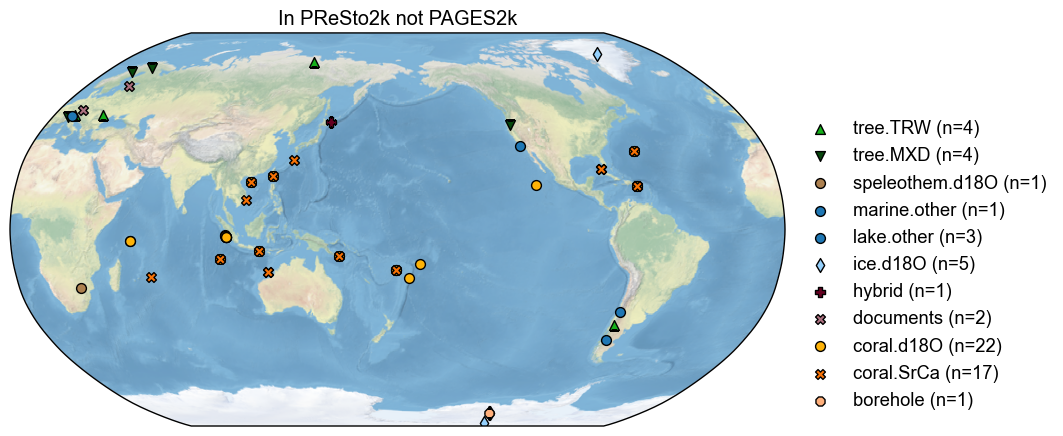

In [10]:
# Plot the map of records not in PAGES2k 

diff = no_interp_fully_renamed - pdb_og

diff.plot(title='In PReSto2k not PAGES2k')

>>> Subtracting SAm_020 failed.
>>> Subtracting LPDb9285123 failed.
>>> Subtracting Eur_026 failed.
>>> Subtracting SAm_0243 failed.
>>> Subtracting Eur_022 failed.
>>> Subtracting Ant_037 failed.
>>> Subtracting NAm_3100 failed.
>>> Subtracting SAm_032 failed.
>>> Subtracting Eur_002 failed.
>>> Subtracting Arc_031 failed.
>>> Subtracting Eur_017 failed.
>>> Subtracting Eur_016 failed.
>>> Subtracting Arc_058 failed.
>>> Subtracting Ant_031dD failed.
>>> Subtracting Ant_031 failed.
>>> Subtracting Eur_018 failed.
>>> Subtracting O2kLR_183 failed.
>>> Subtracting Ant_050 failed.
>>> Subtracting Asia_235 failed.
>>> Subtracting Eur_014 failed.
>>> Subtracting Arc_023 failed.
>>> Subtracting Africa_001 failed.
>>> Subtracting Ocean2kHR_011_iso2k failed.
>>> Subtracting KA17RYU01_SrCa failed.
>>> Subtracting FL17DTO02_SrCa failed.
>>> Subtracting BO14HTI01_SrCa failed.
>>> Subtracting SA16CLA01_d18O failed.
>>> Subtracting AB20MEN03_d18O failed.
>>> Subtracting AB20MEN02_d18O failed.
>>> 

(<Figure size 1000x1000 with 1 Axes>,
 {'map': <GeoAxes: title={'center': 'In PAGES2k not PReSto2k'}>})

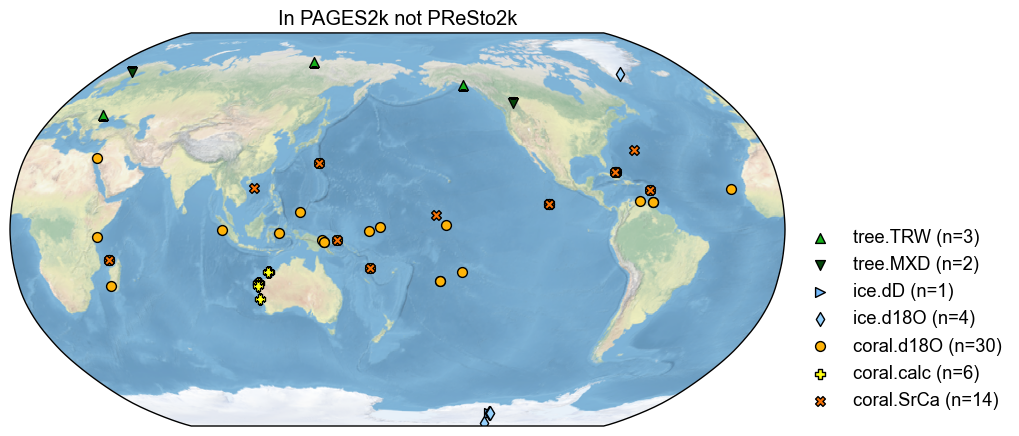

In [11]:
# Plot the map of records not in PReSto2k

diff_other = pdb_og - no_interp_fully_renamed

diff_other.plot(title='In PAGES2k not PReSto2k')

We see that the PReSto 2k criteria dropped a number of records, notably 6 coral calcification records from Western Australia. Multiple coral sites also appear to have been common to both PAGES 2k and CoralHydro2k, and might simply have been swapped from PAGES 2k to PReSto 2k. 

In [12]:
print(f'There are {len(diff.records)} in PReSto2k but NOT in PAGES2k')
print(f'There are {len(diff_other.records)} in PAGES2k but NOT in PReSto2k')

There are 61 in PReSto2k but NOT in PAGES2k
There are 60 in PAGES2k but NOT in PReSto2k


## Comparing Metadata vs. Class-Based Seasonality

We will now run the same renaming/matching test on metadata-based and class-based seasonality. The two differ because not every record in these databases contains seasonality metadata. In this analysis, we chose to drop the records that do not contain this information. A more permissive approach would be to assign class-based seasonality to those records instead of dropping them altogether. 

One important difference of note is that we are doing this comparison before calibration. The calibration step automatically filters out a number of records that do not meet certain requirements (See: _Run Data Assimilation_). Due to this, the `class_og` proxy database is unfiltered from the get-go (initial LiPD dataframe) and not filtered by resolution unlike the metadata ones (both with and without interpolation). During calibration, ~120 records get removed and hence this current proxy database appears significantly larger than what is actually assimilated in the DA step. 

In a further experiment, it will be helpful to compare just the records that were used post-calibration between the two Proxy Databases to get a full breakdown for why one reconstruction outperforms the other. 

In [13]:
class_og = cfr.ProxyDatabase().load_nc('./prev_data/lipd_pdb_pids.nc')
class_og.refresh()

In [14]:
matches_2, conflicts_2, missing_2 = match_proxy_records(class_og, no_interp_pdb)

In [15]:
# Re-run the renaming with all matches
no_interp_fully_renamed_2 = rename_pids(no_interp_pdb, matches_2, in_place=False)

In [16]:
diffo = class_og - no_interp_fully_renamed_2
diffo2 = no_interp_fully_renamed_2-class_og

>>> Subtracting Ocean2kHR_095 failed.
>>> Subtracting Ant_031dD failed.
>>> Subtracting Ocean2kHR_157 failed.
>>> Subtracting Ocean2kHR_158 failed.
>>> Subtracting FL17DTO02_SrCa failed.
>>> Subtracting AB20MEN03_d18O failed.
>>> Subtracting AB20MEN07_d18O failed.
>>> Subtracting LI04FIJ01_SrCa failed.
>>> Subtracting LI06FIJ01_d18O failed.
>>> Subtracting Ocn_066 failed.
>>> Subtracting Asi_324 failed.
>>> Subtracting Ocn_156 failed.
>>> Subtracting Ant_010 failed.
>>> Subtracting Arc_051 failed.
>>> Subtracting Ocn_045 failed.
>>> Subtracting Arc_040 failed.
>>> Subtracting Ocn-EmeraldBasin.Keigwin.2007_LPD68872399 failed.
>>> Subtracting Ant-DSS.DahlJensen.1999_LPD7abab671 failed.
>>> Subtracting NAm_3810 failed.
>>> Subtracting Ocn_194 failed.
>>> Subtracting Ocn_193 failed.
>>> Subtracting Ocn-MD98-2160.Newton.2010_LPD7e8e8eaa failed.
>>> Subtracting Ocn-WestSpitzberg.Bonnet.2010_LPD995c6f3c failed.
>>> Subtracting Ocn_074 failed.
>>> Subtracting NAm_3804 failed.
>>> Subtracting O

(<Figure size 1000x1000 with 1 Axes>,
 {'map': <GeoAxes: title={'center': 'in PReSto2k class not metadata'}>})

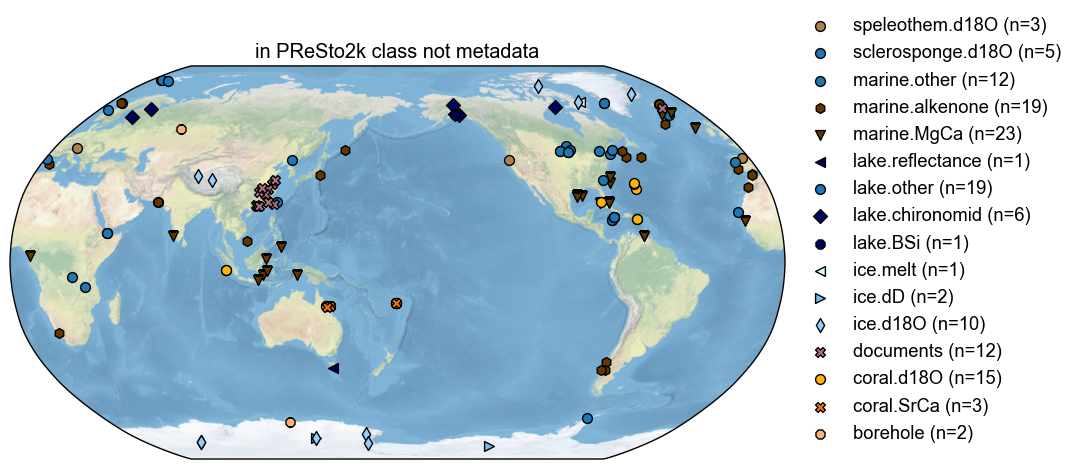

In [17]:
diffo.plot(title='in PReSto2k class not metadata')

(<Figure size 1000x1000 with 1 Axes>,
 {'map': <GeoAxes: title={'center': 'in PReSto2k metadata, not class'}>})

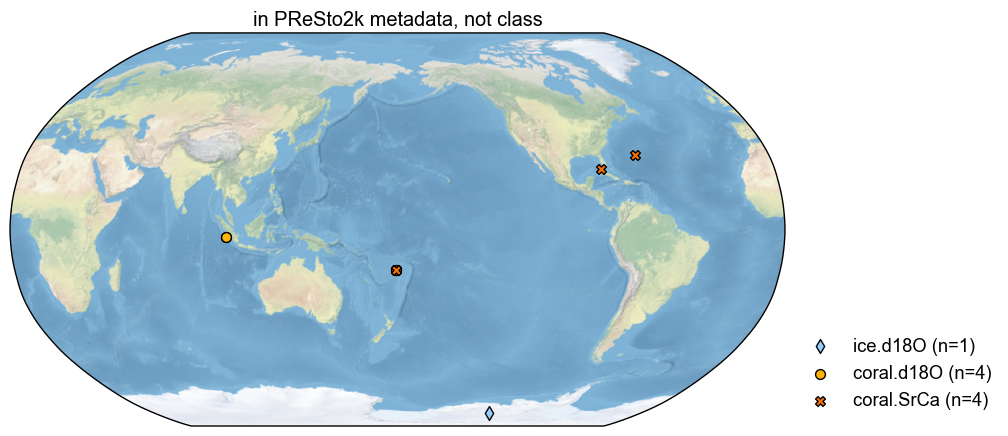

In [18]:
diffo2.plot(title='in PReSto2k metadata, not class')